# **Introduction to In-Context Learning Demo: Pattern Completion using the ARC Corpus**

In this notebook we present a complete step-by-step walkthrough of how Large Language Models (LLMs) can **learn and apply visual completion and transformation patterns purely from few-shot examples**. Inspired by *[Large Language Models as General Pattern Machines](https://arxiv.org/pdf/2307.04721)* (Mirchandani et al., 2023), this demo uses the Abstract and Reasoning Corpus (ARC) introduced in  *[On the Measure of Intelligence](https://arxiv.org/pdf/1911.01547)* (Chollet, 2019) as the source of structured input–output patterns and evaluates Gemini’s ability to recognize and generalize these patterns through in-context learning (ICL). The goal is to illustrate how an LLM without updates to any weights can observe a handful of small grid transformations and then correctly generate the missing output for a novel test example. The result is a learning paradigm that is purely based on the forward pass of the LLM without requiring any gradient-based updates.

## **Overview**

This demonstration guides you through:
1.   Loading the ARC tasks
2.   Constructing an ICL prompt composed of example input–output pairs
3.   Prompting Gemini using the constructed prompt for it to infer the underlying transformation
4. Extract and render the model’s predicted test output

The result is a clear visualization of how LLMs can act as pattern machines, discovering abstract rules from minimal supervision.

## **Background**
The Abstract and Reasoning Corpus (ARC) is a benchmark introduced by François Chollet to evaluate generalization, abstraction, and concept learning in AI systems. Unlike standard vision datasets, ARC focuses on Few-shot learning and minimal prior knowledge. The underlying hypothesis is that the learning systems would discover abstract rules that allow for human-like pattern induction.

## **Let's Take a Look at an Example**

The figure below shows an example from the ARC dataset and demonstrates how a model identifies and applies a transformation rule. The training examples provide few-shot demonstrations of the underlying pattern. Each training example has an input pattern and an output pattern. In the example below, the output can be regarded as a de-noised version of the input. The test query is a new input from the corpus that follows the same rule. In the case below, the test query is an input image that includes a number of noisy or corrupted pixels. The task of the LLM is to generate the corrected output image which adjusts for these corrupted pixels. The underlying assumption of ICL is that the large language model can learn what sort of transformation to perform, e.g., de-noising, from the few-shot examples alone.

<img src="https://raw.githubusercontent.com/intro-to-icl/intro-to-icl.github.io/refs/heads/master/static/images/sequence_transformation_1.png" height="500">

**In this specific example, the learned transformation is a de-noising operation that fills in and removes any corrupted pixels or segments.**

## **LLM as the Optimizer**
In our demo, we leverage Gemini 2.0/2.5 Flash to perform in-context learning (ICL) on Abstraction and Reasoning Corpus (ARC)–style grid transformation tasks. Unlike traditional supervised learning approaches, the LLM is never trained on the task. Instead, it infers the underlying transformation rule purely from the examples we provide in the prompt.

The process can be understood as a sequence of structured steps: preparing the training examples, constructing a carefully engineered prompt, invoking the LLM to infer the rule, and finally converting its output back into a grid. The LLM behaves as a reasoning engine, reading the examples like a story and deducing the pattern that connects them.

## **Code Overview**
The implementation is organized into a modular structure, with each component responsible for a different stage of the ARC task-solving pipeline. This design separates data loading, visualization, prompt construction, LLM inference, and result interpretation, making the system easy to understand, modify, and extend.

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**


### ***Note: Run all the cells below to initialize the environment.**





In [ ]:
#@title **Import Necessary Libraries**
import numpy as np
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
import re
import itertools
import math
import ast
import json
import ipywidgets as widgets
from IPython.display import display
import os
import getpass

In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")
client = genai.Client(api_key=apikey)

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash")
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

In [ ]:
#@title **Download Data from GitHub**
if not os.path.exists("intro_to_icl_data"):
    !git clone https://github.com/hsiang-fu/intro_to_icl_data.git



Cloning into 'intro_to_icl_data'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 172 (delta 63), reused 115 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 17.23 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (63/63), done.


The below cell `Grid Display Function` is responsible for the entire grid display and visual interpretation layer of the ARC demo. Its purpose is to transform the raw numerical grids—integers ranging from 0 to 9—into the colored, human-readable visualizations used throughout the notebook.

ARC tasks define grids where each integer corresponds to a color category. The `arc_colors` dictionary encodes this mapping using RGB triplets.
For example:
- 0 → black,
- 1 → blue,
- 2 → green,
- 3 → red, etc.

**These colors reflect the official ARC palette.**

In [ ]:
#@title **Grid Display Function**
arc_colors = {
    0: (0, 0, 0),
    1: (0, 0, 255),
    2: (0, 255, 0),
    3: (255, 0, 0),
    4: (255, 255, 0),
    5: (255, 165, 0),
    6: (128, 0, 128),
    7: (150, 75, 0),
    8: (128, 128, 128),
    9: (255, 192, 203)
}

def show_grid(grid, title=""):
    arr = np.array(grid)
    rgb = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)
    for k, v in arc_colors.items():
        rgb[arr == k] = v
    plt.imshow(rgb)
    plt.axis("off")
    if title:
        plt.title(title)

The below cell `ARC ICL Demo` is responsible for running the full interactive ARC demo, including user task selection, prompt construction, LLM inference, visualization of training/test grids, parsing model outputs, and saving the results. It effectively acts as the end-to-end execution and UI layer of the entire notebook.

The cell creates a simple user interface, consisting of :
- A dropdown menu that lists ARC tasks (Task 1 through Task 10),
- A button to confirm the selection.
- **This makes the demo interactive, users can dynamically choose which ARC task they want to solve without modifying any code.**

The model will then generate and running the visualization cell would show the following:

- Training examples
- Test example
- Expected output
- Model-generated output

### **Let's Take a Look at an Example of a Prompt:**
```
Train:
Example 1 Input: [[0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0]] -> Example 1 Output: [[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]]
Example 2 Input: [[0, 3, 0, 0, 0, 3, 3, 0, ..., 0, 0, 0]] -> Example 2 Output: [[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]]
Example 3 Input: [[0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]] -> Example 3 Output: [[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]]

Test Input: [[0, 0, 3, 3, 0, 0, 0, 0, ..., 3, 0, 0, 0, 0]] ->
```

This prompt shows the model three training examples and one test query from an ARC task (same task as the image above), where each example provides an input grid. The grid consists of rows of colored cells represented by a list of numbers (each number corresponds to a color) and a corresponding output grid that reflects how the grid changes after applying a hidden transformation rule. In ARC, the model’s objective is to infer this underlying pattern solely from the provided examples and then apply it to the test input to generate the appropriate output.

This is considered ICL because the model is not being updated or fine-tuned. All “learning” occurs within the prompt itself: the examples become the model’s temporary training data. By observing the input–output pairs embedded in the prompt, the model identifies the pattern, generalizes it, and produces the appropriate output for the test query—all during a single forward pass of the LLM.

In [ ]:
#@title **ARC ICL Demo — Model Call & Inference**

def count_pixel_differences(a, b):
    diff = 0
    for r1, r2 in zip(a, b):
        for p1, p2 in zip(r1, r2):
            if p1 != p2:
                diff += 1
    return diff

dropdown = widgets.Dropdown(
    options=[f"Task {i}" for i in range(1, 11)],
    value="Task 1",
    description="Select Task:",
    style={'description_width': 'initial'}
)

button = widgets.Button(description="Run Inference")

file = None

def run_llm_inference(file):
    file_path = "intro_to_icl_data/" + file + ".json"

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    with open(file_path, "r") as f:
        task = json.load(f)

    # Build prompting string
    prompt = "Train:\n"
    for i, example in enumerate(task["train"]):
        prompt += (
            f"Example {i+1} Input: {example['input']} -> "
            f"Example {i+1} Output: {example['output']}\n"
        )
    prompt += f"\nTest Input: {task['test'][0]['input']} -> "

    # Run LLM
    response = client.models.generate_content(
        model=model_name,
        contents=[prompt],
        config=types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(thinking_budget=0)
        ),
    )

    # Extract output tokens
    match = re.search(r"\[.*\]", response.text, re.DOTALL)
    if not match:
        print("No valid output found in model response.")
        return None

    # Save original ground truth
    task["test"][0]["ground_truth"] = task["test"][0]["output"]
    try:
        task["test"][1]["ground_truth"] = task["test"][1]["output"]
    except:
        pass
    # Save model output
    task["test"][0]["output"] = ast.literal_eval(match.group(0))

    # Write output JSON
    directory, filename = os.path.split(file_path)
    output_filename = "output_" + filename
    output_file_path = os.path.join(directory, output_filename)

    with open(output_file_path, "w") as f:
        json.dump(task, f, indent=2)

    print(f"\nLLM output saved to: {output_file_path}")
    return output_file_path

def on_button_click(b):
    global file
    file = dropdown.value
    print(f"\nRunning LLM inference for: {file}…")
    run_llm_inference(file)

button.on_click(on_button_click)

display(widgets.VBox([dropdown, button]))


Running LLM inference for: Task 9…

LLM output saved to: intro_to_icl_data/output_Task 9.json


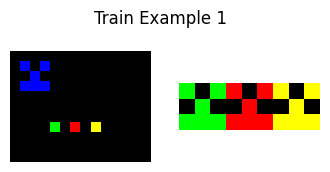

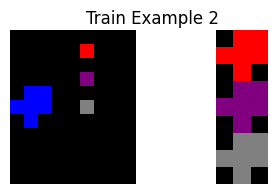

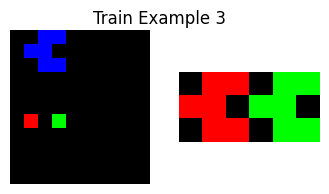

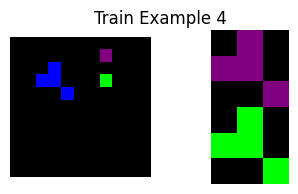

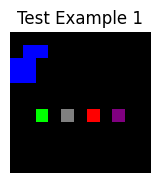

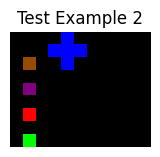

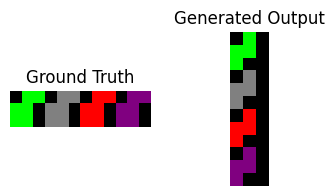


The Number of Pixel Differences Between the Predicted Output and Ground Truth is: 2



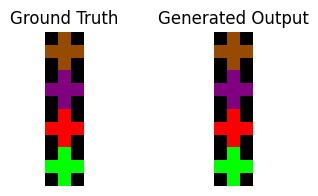


The Number of Pixel Differences Between the Predicted Output and Ground Truth is: 0



In [ ]:
#@title **ARC ICL Demo — Visualization**

def visualize_results(file):
    file_path = "intro_to_icl_data/output_" + file + ".json"

    if not os.path.exists(file_path):
        print("Run inference first — output file not found.")
        return

    with open(file_path, "r") as f:
        output = json.load(f)

    # Visualize train examples
    for i, pair in enumerate(output["train"]):
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        show_grid(pair["input"], "")
        plt.subplot(1, 2, 2)
        show_grid(pair["output"], "")
        plt.suptitle(f"Train Example {i+1}")
        plt.show()

    for i, pair in enumerate(output["test"]):
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        show_grid(pair["input"], f"Test Example {i+1}")
        plt.show()

    # Visualize test results
    for i, pair in enumerate(output["test"]):
        generated = pair["output"]
        ground_truth = pair.get("ground_truth", None)

        plt.figure(figsize=(4, 2))

        if ground_truth:
            plt.subplot(1, 2, 1)
            show_grid(ground_truth, "Ground Truth")

            plt.subplot(1, 2, 2)
            show_grid(generated, "Generated Output")
        else:
            show_grid(generated, "Generated Output")

        plt.show()

        if ground_truth:
            try:
                diff = count_pixel_differences(ground_truth, generated)
                print(f"\nThe Number of Pixel Differences Between the Predicted Output and Ground Truth is: {diff}\n")
            except:
                print("\nError comparing outputs.\n")

# Run it manually after inference:
visualize_results(file)

## **Summary**
This demo showcases how Large Language Models can perform in-context learning by recognizing visual transformation patterns from a small number of examples. Using tasks from the Abstract and Reasoning Corpus (ARC), we construct prompts that present input–output grid pairs and then ask the model to generate the missing transformation for a new test input. Through this setup, we observe how the model identifies the hidden rule by examining the structure of the grids rather than relying on built-in symbolic reasoning.

Beyond the specific task illustrated here, the same methodology can be applied to a wide spectrum of ARC-style transformations. By crafting carefully chosen few-shot examples, we can guide the model toward discovering diverse rules such as color mappings, object counting, symmetry detection, region extraction, movement operations, and shape reconstruction. These extensions demonstrate how flexible the in-context learning framework is when applied to structured, symbolic data.

## **Conclusion**
This demonstration highlights that LLMs can generalize abstract rules similar to human inductive reasoning, even when reasoning over symbolic grid data. By providing only a few examples, the model can infer the underlying transformation and apply it to new cases—capturing the essence of in-context learning. Although the model does not perform explicit algorithmic reasoning, its ability to internalize and reproduce patterns suggests strong potential for tasks requiring rapid generalization from limited data. ARC serves as a valuable testing ground for understanding these capabilities, revealing both the promise and the limitations of treating LLMs as general pattern machines.

## **References**
Chollet, F. (2019). On the Measure of Intelligence. *arXiv preprint arXiv:1911.01547.*

Mirchandani, S., Xia, F., Florence, P., Ichter, B., Driess, D., Arenas, M.G., Rao, K., Sadigh, D. and Zeng, A. (2023, December). Large Language Models as General Pattern Machines. *In Conference on Robot Learning* (pp. 2498-2518). PMLR.